In [1]:
# Data description

# There are 3 types of input features:
# 1 Objective: factual information
# 2 Examination: results of medical examination
# 3 Subjective: information given by the patient

In [2]:
# Import all required modules
import pandas as pd
import numpy as np

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Import plotting modules
import seaborn as sns
sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

In [3]:
# Tune the visual settings for figures in `seaborn`
sns.set_context(
    "notebook", 
    font_scale=1.5,       
    rc={ 
        "figure.figsize": (11, 8), 
        "axes.titlesize": 18 
    }
)

from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

In [4]:
df = pd.read_csv('Cardiovascular_disease.csv')

# Overall info.
print('Dataset size: ', df.shape)
df.head()

Dataset size:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


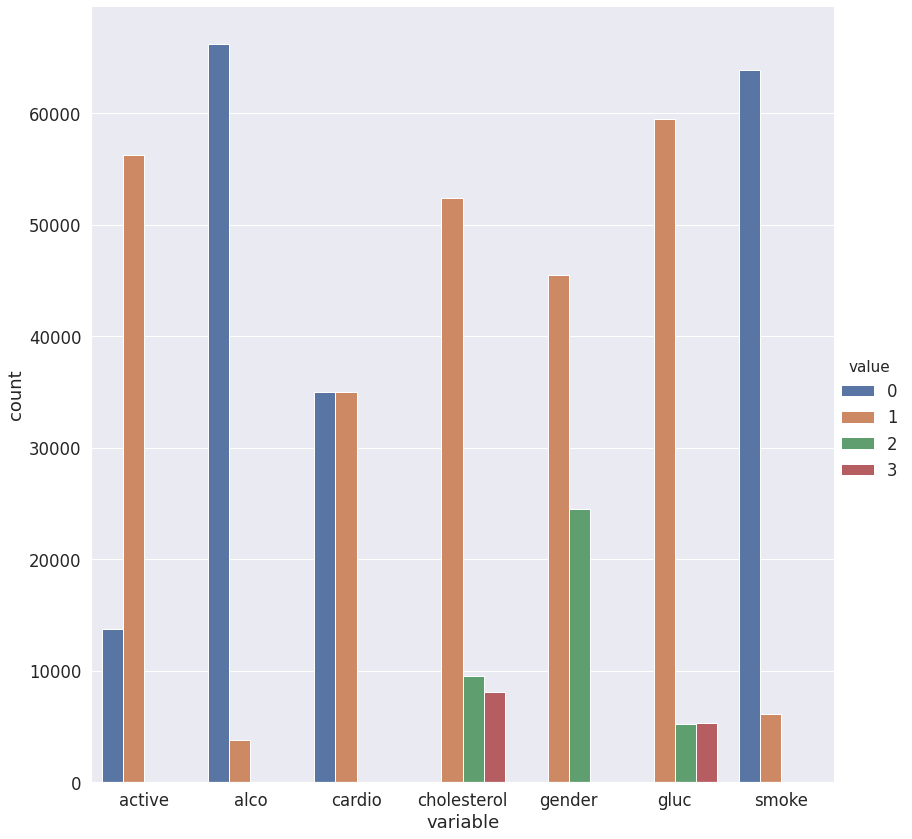

In [5]:
# Let's convert the data into long format and depict the value counts of the categorical features using factorplot().

df_uniques = pd.melt(frame=df, value_vars=[
    'gender','cholesterol', 'gluc', 'smoke',
    'alco', 'active', 'cardio'
])

df_uniques = pd.DataFrame(
    df_uniques.groupby(['variable', 'value'])['value'].count()
).sort_index(level=[0, 1]).rename(columns={'value': 'count'}).reset_index()

sns.factorplot(
    x='variable', y='count', hue='value', 
    data=df_uniques, kind='bar', size=12
);

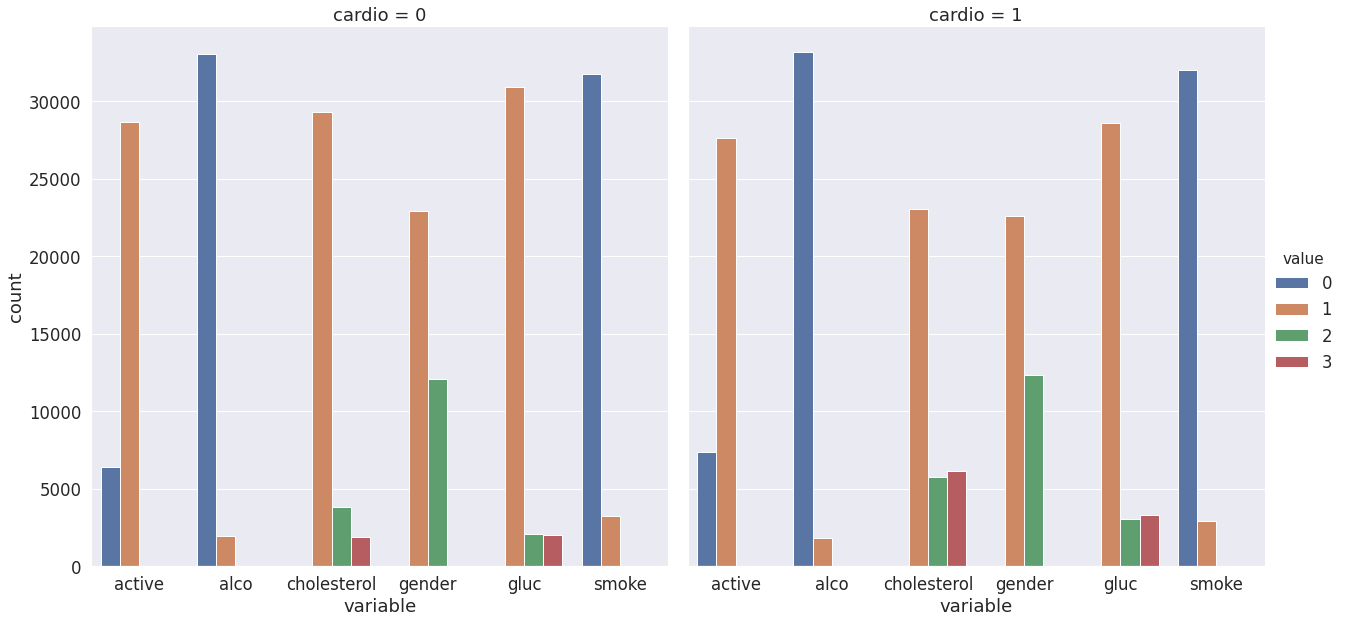

In [6]:
# Let's split the dataset by target values.
# Can you already spot the most significant feature by just looking at the plot?

df_uniques = pd.melt(
    frame = df,
    value_vars = [
        'gender','cholesterol', 'gluc', 'smoke', 'alco', 'active'
    ],
    id_vars = ['cardio']
)

df_uniques = pd.DataFrame(
    df_uniques.groupby(['variable', 'value', 'cardio'])['value'].count()
).sort_index(level=[0, 1]).rename(columns={'value': 'count'}).reset_index()

sns.factorplot(
    x='variable', y='count', hue='value', 
    col='cardio', data=df_uniques, kind='bar', size=9
);

In [7]:
# Now, let's calculate some statistics for the feature unique values.

for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * '-')

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


In [8]:
# How many men and women are present in this dataset?
# Values of the gender feature were not given (whether "1" stands for women or for men) –
# figure this out by looking analyzing height,
# making the assumption that men are taller on average.

variants = ['men', 'women']

a = variants.pop(0) if (
        df[df['gender'] == 1].mean()['height'] > df[df['gender'] == 2].mean()['height']
    ) else variants.pop(-1)
b = variants[0]

df['gender'].replace({1: a, 2: b}, inplace=True);
print(df['gender'].value_counts());

women    45530
men      24470
Name: gender, dtype: int64


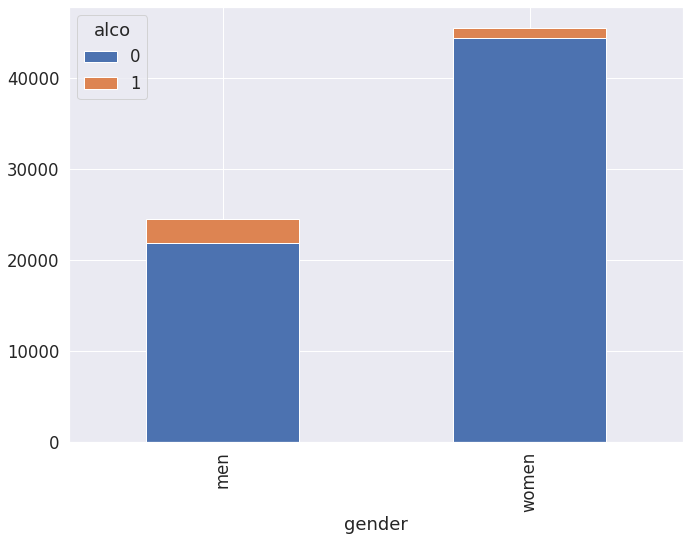

In [9]:
# Which gender more often reports consuming alcohol - men or women?

ct = pd.crosstab(df['gender'], df['alco'])
ct.plot.bar(stacked=True);

In [10]:
# What is the difference between the percentages of smokers among men and women (rounded)?
# df.groupby('gender')['smoke'].mean()

print(pd.crosstab(df['gender'], df['smoke']))

women_sex = df[df['gender'] == 'women']
men_sex = df[df['gender'] == 'men']
women_sex_counter = women_sex.shape[0]
men_sex_counter = men_sex.shape[0]

different = round(
    abs(
        (women_sex[women_sex['smoke'] == 1].shape[0] / women_sex_counter * 100) - 
        (men_sex[men_sex['smoke'] == 1].shape[0] / men_sex_counter * 100)
    ), 2
)

different

smoke       0     1
gender             
men     19114  5356
women   44717   813


20.1

In [11]:
# What is the difference between median values of age for smokers and non-smokers (in months, rounded)?
# You'll need to figure out the units of feature age in this dataset.

smokers = df[df['smoke'] == 1]['age'].median()
not_smokers = df[df['smoke'] == 0]['age'].median()

round(abs(smokers-not_smokers) / 30, 2)

19.9

In [12]:
# For this task, select only the people of age 60 to 64, inclusive.
# Cholesterol level categories differ between the figure and our dataset.
# The conversion for the cholesterol feature is as follows:
# 4 mmol/l  →→  1, 5-7 mmol/l  →→  2, 8 mmol/l  →→  3.


df['age_years'] = round(df['age'] / 365.25)  # Add new feature to DataFrame.
seventy_smokers = df[(df['age_years'] >= 60) & (df['age_years'] <= 64) & (df['smoke'] == 1)]

seventy_smokers[
    (seventy_smokers['cholesterol'] == 3) &
    (seventy_smokers['ap_hi'] >= 160) &
    (seventy_smokers['ap_hi'] < 180)
]['cardio'].mean() / seventy_smokers[
    (seventy_smokers['cholesterol'] == 1) &
    (seventy_smokers['ap_hi'] <120)
]['cardio'].mean()

3.192307692307692

In [13]:
# Create a new feature – BMI (Body Mass Index).
# To do this, divide weight in kilogramms by the square of the height in meters.
# Normal BMI values are said to be from 18.5 to 25.

df['BMI'] = df['weight'] / (df['height'] / 100) ** 2

# Median BMI in the sample is NOT within the range of normal BMI values.
print(df.mean()['BMI']);

# The BMI for women is on average higher than for men.
# df.groupby('gender')['BMI'].median()
print(df[df['gender'] == 'women'].mean()['BMI']);
print(df[df['gender'] == 'men'].mean()['BMI']);

# Healthy people NOT have, on average, higher BMI than the people with CVD.
# df.groupby(['gender', 'alco', 'cardio'])['BMI'].median().to_frame()
print(df[df['cardio'] == 1].mean()['BMI']);  
print(df[df['cardio'] == 0].mean()['BMI']);

# For healthy, non-drinking men, BMI is closer to the norm than for healthy, non-drinking women.
print(df[(df['alco'] == 0) & (df['cardio'] == 0) & (df['gender'] == 'women')].mean()['BMI']);
print(df[(df['alco'] == 0) & (df['cardio'] == 0) & (df['gender'] == 'men')].mean()['BMI']);

27.55651255127886
27.98758344183285
26.754442357289356
28.56606062701535
26.5481752067945
26.845406594131507
25.87263807546017


In [14]:
"""
Filter out the following patient segments (we consider these as erroneous data)

diastolic pressure is higher than systolic
height is strictly less than 2.5 percentile (Use pd.Series.quantile)
height is strictly more than 97.5 percentile
weight is strictly less than 2.5 percentile
weight is strictly more than 97.5 percentil

What percent of the original data (rounded) did we throw away?
""";
filtered_df = df[(df['ap_hi'] > df['ap_lo']) &
    (df['height'] >= df['height'].quantile(0.025)) &
    (df['height'] <= df['height'].quantile(0.975)) &
    (df['weight'] <= df['weight'].quantile(0.975)) &
    (df['weight'] >= df['weight'].quantile(0.025))
  ]
throwed_away = round(100 - filtered_df.shape[0] / df.shape[0] * 100)
throwed_away

10

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
0,0,18393,men,168,62.0,110,80,1,1,0,0,1,0,50.0,21.967120
1,1,20228,women,156,85.0,140,90,3,1,0,0,1,1,55.0,34.927679
2,2,18857,women,165,64.0,130,70,3,1,0,0,0,1,52.0,23.507805
3,3,17623,men,169,82.0,150,100,1,1,0,0,1,1,48.0,28.710479
4,4,17474,women,156,56.0,100,60,1,1,0,0,0,0,48.0,23.011177


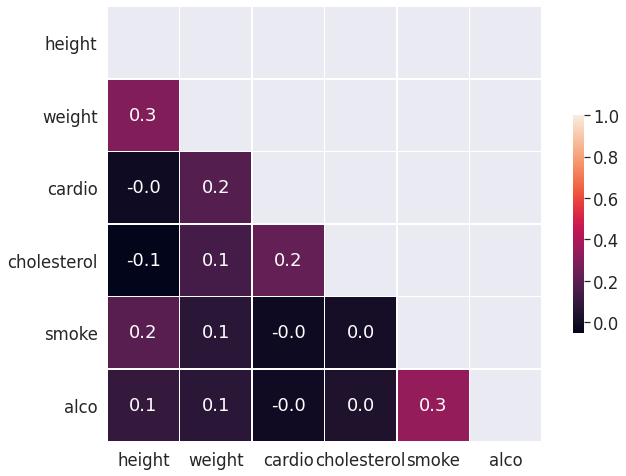

In [15]:
# Plot a correlation matrix using heatmap().
# You can create the matrix using the standard pandas tools with the default parameters.
# Which pair of features has the strongest Pearson's correlation with the gender feature?
# Cardio, Cholesterol
# * Height, Smoke
# Smoke, Alco
# Height, Weight

features = ['height', 'weight', 'cardio', 'cholesterol', 'smoke', 'gender', 'alco']
corr = df[features].corr()
# Create a mask to hide the upper triangle of the correlation matrix (which is symmetric)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True, fmt='.1f', square=True, linewidths=.5,cbar_kws={"shrink": .5});
df.head()

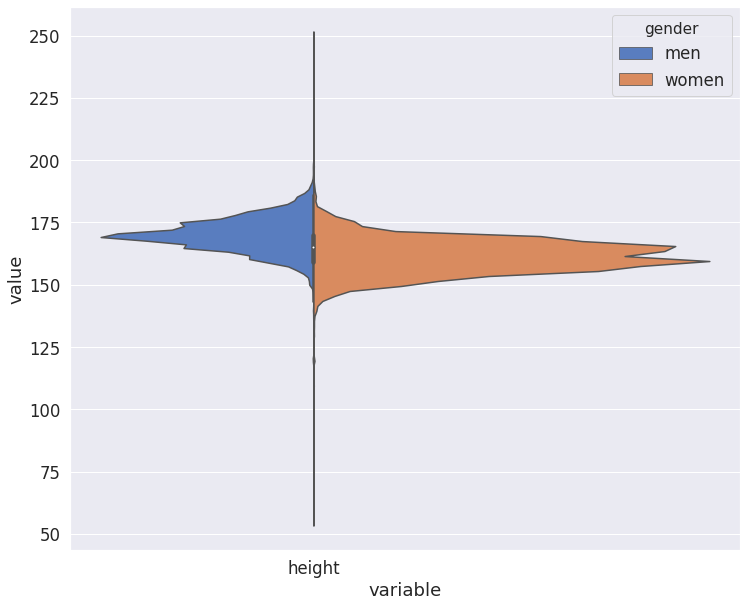

In [16]:
"""Create a violin plot for the height and gender using violinplot(). Use the parameters:

hue to split by gender;
scale to evaluate the number of records for each gender.

In order for the plot to render correctly, 
you need to convert your DataFrame to long format using the melt() function from pandas. 
""";
df_melt = pd.melt(frame=df, value_vars=['height'], id_vars=['gender'])

plt.figure(figsize=(12, 10))
ax = sns.violinplot(
    x='variable', 
    y='value', 
    hue='gender', 
    palette="muted", 
    split=True, 
    data=df_melt, 
    scale='count',
    scale_hue=False
)

In [17]:
"""
In most cases, the Pearson coefficient of linear correlation is more than enough to discover patterns in data.
But let's go a little further and calculate a rank correlation.
It will help us to identify such feature pairs in which the lower rank in the 
variational series of one feature always precedes the higher rank in the another one 
(and we have the opposite in the case of negative correlation).

Task:
Calculate and plot a correlation matrix using the Spearman's rank correlation coefficient.


# Which pair of features has the strongest Spearman correlation?
# Height, Weight      0.313569
# Cholesterol, Gluc   0.407803
# Cardio, Cholesterol 0.215117
# Ap_hi, Ap_lo        0.735436
# Smoke, Alco         0.340094

Why do these features have strong rank correlation?
Inaccuracies in the data (data acquisition errors).
Relation is wrong, these features should not be related.
Nature of the data.                                       
""";

df.corr(method='spearman')

,id,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
id,1.000000,0.002682,-0.001886,-0.001292,0.003258,-0.000238,0.005706,0.002789,-0.003697,0.001214,0.003766,0.003800,0.002367,-0.000472
age,0.002682,1.000000,-0.082292,0.061559,0.219087,0.156700,0.140113,0.091791,-0.047471,-0.030078,-0.010422,0.234429,0.998088,0.107610
height,-0.001886,-0.082292,1.000000,0.313569,0.019381,0.030534,-0.058940,-0.024369,0.197632,0.096670,-0.007367,-0.012383,-0.083594,-0.182390
weight,-0.001292,0.061559,0.313569,1.000000,0.277749,0.254420,0.137908,0.109901,0.071676,0.068088,-0.014894,0.182701,0.062956,0.848271
ap_hi,0.003258,0.219087,0.019381,0.277749,1.000000,0.735436,0.208722,0.105334,0.028929,0.033243,-0.001268,0.451885,0.220663,0.281102
ap_lo,-0.000238,0.156700,0.030534,0.254420,0.735436,1.000000,0.167401,0.082474,0.026172,0.038862,0.003401,0.362572,0.157794,0.250609
cholesterol,0.005706,0.140113,-0.058940,0.137908,0.208722,0.167401,1.000000,0.407803,0.015220,0.041285,0.007573,0.215117,0.141957,0.174008
gluc,0.002789,0.091791,-0.024369,0.109901,0.105334,0.082474,0.407803,1.000000,0.000468,0.018584,-0.008610,0.091488,0.091661,0.127857
smoke,-0.003697,-0.047471,0.197632,0.071676,0.028929,0.026172,0.015220,0.000468,1.000000,0.340094,0.025858,-0.015486,-0.047532,-0.024264
alco,0.001214,-0.030078,0.096670,0.068088,0.033243,0.038862,0.041285,0.018584,0.340094,1.000000,0.025476,-0.007330,-0.029978,0.022702


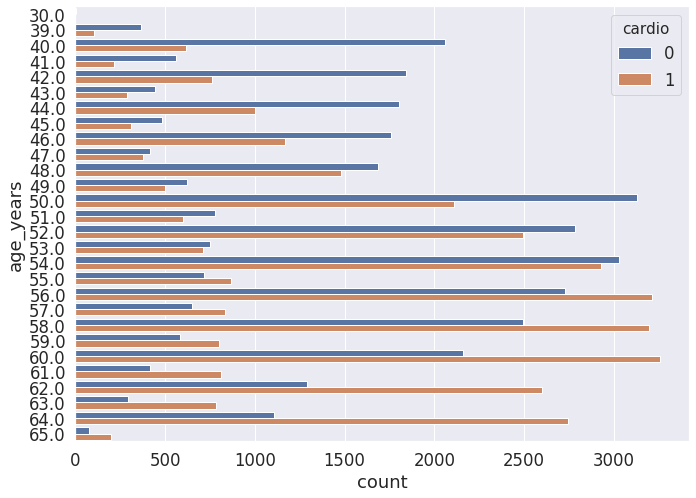

In [18]:
# Create a count plot using countplot() with the age on the X axis and the number of people on the Y axis.
# Your resulting plot should have two columns for each age,
# corresponding to the number of people for each cardio class of that age.
# What is the smallest age at which the number of people with CVD outnumber the number of people without CVD?

sns.countplot(y='age_years', hue='cardio', data=df);